# Ranking system

## 1. Prepare datasets

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

### i) get merchant details

In [2]:
# read in merchant data
merchants = pd.read_csv('../data/curated/agg_merchants.csv')
merchants.rename(columns={'merchant_desc':'category'}, inplace=True)

In [3]:
merchants.head()

,merchant_abn,merchant_name,category,merchant_take_rate,total_num_consumer,total_num_trans,total_revenue,consumer_reliability,merchant_reliability
0,10023283211,Felis Limited,furniture,0.18,3032,3261,703277.711451,0.999693,0.000000
1,10142254217,Arcu Ac Orci Corporation,cable,4.22,2849,3036,118356.146073,1.000000,0.985507
2,10165489824,Nunc Sed Company,jewelry,4.40,5,5,56180.473857,0.800000,1.000000
3,10187291046,Ultricies Dignissim Lacus Foundation,watch,3.29,335,336,39693.730387,1.000000,0.979167
4,10192359162,Enim Condimentum PC,music,6.33,383,385,177980.505456,1.000000,0.984416


### ii) merge with model predictions

In [4]:
# read in model predictions
pred = pd.read_csv("../data/curated/LM_prediction.csv")

# merge with merchant data
merchants = pd.merge(merchants, pred, left_on='merchant_abn', right_on='merchant_abn',  how='left')

# define total gain = total revenue * take rate
merchants["total_gain"] = merchants["total_revenue"] * (merchants["merchant_take_rate"] / 100)
merchants["pred_gain"] = merchants["predicted_revenue"] * (merchants["merchant_take_rate"] / 100)

# drop merchants without predictions
merchants.dropna(inplace=True)

# rename columns and drop unnecessary columns
merchants.rename(columns = {"predicted_total_number_consumers": "pred_num_consumer", "predicted_total_number_transactions": "pred_num_trans"},  inplace = True) 
merchants.drop(['total_revenue', 'predicted_revenue'], axis=1, inplace=True)

## 2. Aggregate categories into bigger segments

In [5]:
# define each category into five bigger segments: luxury, recreational, housing, daily, and IT
segments_dict = {"antique": "luxury",
            "art": "luxury",
            "artist supply": "recreational",
            "bicycle":"housing",
            "books":"recreational",
            "cable":"IT",
            "computer":"IT",
            "digital":"IT",
            "equipment":"housing",
            "florists":"recreational",
            "furniture":"housing",
            "garden":"housing",
            "gift":"recreational",
            "health":"daily",
            "hobby":"recreational",
            "jewelry":"luxury",
            "motor":"housing",
            "music":"recreational",
            "opticians":"daily",
            "shoe":"daily",
            "stationery":"daily",
            "telecom":"IT",
            "tent":"recreational",
            "watch":"luxury"
}

In [6]:
# add the new column that shows which segment that the merchant belongs to
merchants["segment"] = merchants["category"].apply(lambda x: segments_dict[x])

# get separated dataframe to contain merchants from each segment
merchants_luxury = merchants[merchants["segment"]=="luxury"]
merchants_recreational = merchants[merchants["segment"]=="recreational"]
merchants_daily = merchants[merchants["segment"]=="daily"]
merchants_housing = merchants[merchants["segment"]=="housing"]
merchants_IT = merchants[merchants["segment"]=="IT"]

In [7]:
print("# of merchants in luxury segment is", len(merchants_luxury))
print("# of merchants in recreational segment is", len(merchants_recreational))
print("# of merchants in daily segment is", len(merchants_daily))
print("# of merchants in housing segment is", len(merchants_housing))
print("# of merchants in IT segment is", len(merchants_IT))
print("Total # of merchants is", len(merchants))

# of merchants in luxury segment is 494
# of merchants in recreational segment is 1206
# of merchants in daily segment is 661
# of merchants in housing segment is 790
# of merchants in IT segment is 867
Total # of merchants is 4018


## Rank by single features

In [8]:
merchants.sort_values(by='pred_num_trans', ascending=False).head(5)[['merchant_abn', 'merchant_name', 'category','total_num_trans', 'pred_num_trans']]

,merchant_abn,merchant_name,category,total_num_trans,pred_num_trans
680,24852446429,Erat Vitae LLP,florists,289513,183854.0
3443,86578477987,Leo In Consulting,watch,272674,173536.0
2439,64203420245,Pede Nonummy Corp.,tent,260780,165578.0
1827,49891706470,Non Vestibulum Industries,tent,247526,157091.0
1694,46804135891,Suspendisse Dui Corporation,opticians,234362,149493.0


In [9]:
merchants.sort_values(by='pred_num_consumer', ascending=False).head(5)[['merchant_abn', 'merchant_name', 'category','total_num_consumer', 'pred_num_consumer']]

,merchant_abn,merchant_name,category,total_num_consumer,pred_num_consumer
680,24852446429,Erat Vitae LLP,florists,24080,135426.0
3443,86578477987,Leo In Consulting,watch,24081,130107.0
2439,64203420245,Pede Nonummy Corp.,tent,24081,125632.0
1827,49891706470,Non Vestibulum Industries,tent,24078,120701.0
1694,46804135891,Suspendisse Dui Corporation,opticians,24079,115946.0


In [10]:
merchants.sort_values(by='pred_gain', ascending=False).head(5)[['merchant_abn', 'merchant_name', 'category','total_gain', 'pred_gain']]

,merchant_abn,merchant_name,category,total_gain,pred_gain
3154,79827781481,Amet Risus Inc.,furniture,663870.306938,413863.935874
1766,48534649627,Dignissim Maecenas Foundation,opticians,624754.819558,396059.134193
1034,32361057556,Orci In Consequat Corporation,gift,623617.326307,394349.647795
3443,86578477987,Leo In Consulting,watch,613410.587919,390640.318996
1637,45629217853,Lacus Consulting,gift,585975.339604,372704.465598


## Check correlation between features

In [11]:
feature_set2 = merchants[['pred_gain', 'pred_num_consumer', 'pred_num_trans', 'merchant_reliability', 'consumer_reliability']]
feature_set2.corr()

,pred_gain,pred_num_consumer,pred_num_trans,merchant_reliability,consumer_reliability
pred_gain,1.000000,0.582228,0.554717,0.069419,0.010962
pred_num_consumer,0.582228,1.000000,0.995200,0.024975,0.034676
pred_num_trans,0.554717,0.995200,1.000000,0.023371,0.030479
merchant_reliability,0.069419,0.024975,0.023371,1.000000,-0.011381
consumer_reliability,0.010962,0.034676,0.030479,-0.011381,1.000000


In [12]:
# extract only the important feaatures
important_features = ['merchant_name', 'category', 'segment', 'pred_num_trans', 'pred_gain', 'pred_num_consumer', 'merchant_reliability', 'consumer_reliability']
merchants_sub = merchants[important_features]

# save the current merchant dataframe for later purpose
merchants_sub.to_csv("../data/curated/merchants_preSorted",index=False)

## Top 100 merchants

In [13]:
# define the feature weights used in the ranking system
default_weights = {"pred_gain": 0.4, "pred_num_consumer": 0.25, "pred_num_trans": 0.25, "merchant_reliability": 0.05, "consumer_reliability": 0.05}
criteria = default_weights.keys()

In [14]:
# normalize the feature values
merchants_subset = merchants_sub[criteria]
normalized_df = (merchants_subset - merchants_subset.min()) / (merchants_subset.max() - merchants_subset.min())

# calculate the weighted sum of feature values for every merchant
default_weighted_sum = normalized_df.apply(lambda col: col * default_weights[col.name]).sum(axis=1)
merchants_sub["default_weighted_sum"] = default_weighted_sum

# sort the merchants by this weighted sum value = merchant rating
merchants_sorted = merchants_sub.sort_values(by='default_weighted_sum', ascending=False)
merchants_sorted = merchants_sorted.reset_index(drop=True)

# add feauture indicating the ranking of the merchant
merchants_sorted["rank"] = merchants_sorted.index+1

/var/folders/np/m1q4q1w54q59sj70tvylvg5m0000gn/T/ipykernel_2874/1826195525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merchants_sub["default_weighted_sum"] = default_weighted_sum


In [15]:
# top 100 merchants (showing first 20 merchants)
top100_merchants = merchants_sorted.head(100)
top100_merchants.head(20)

,merchant_name,category,segment,pred_num_trans,pred_gain,pred_num_consumer,merchant_reliability,consumer_reliability,default_weighted_sum,rank
0,Leo In Consulting,watch,luxury,173536.0,390640.318996,130107.0,0.985228,0.999791,0.953038,1
1,Lacus Consulting,gift,recreational,145209.0,372704.465598,113733.0,0.985503,0.999825,0.867038,2
2,Est Nunc Consulting,tent,recreational,137610.0,340722.911863,108809.0,0.983872,0.999810,0.816735,3
3,Non Vestibulum Industries,tent,recreational,157091.0,264025.573710,120701.0,0.981982,0.999778,0.791217,4
4,Erat Vitae LLP,florists,recreational,183854.0,162804.614803,135426.0,0.991085,0.999827,0.757767,5
5,Lorem Ipsum Sodales Industries,florists,recreational,127566.0,257363.423451,102536.0,0.981246,0.999806,0.711089,6
6,Pede Nonummy Corp.,tent,recreational,165578.0,137339.140382,125632.0,0.991058,0.999831,0.690313,7
7,Mauris Non Institute,cable,IT,76224.0,363062.301237,66851.0,0.983958,0.999834,0.677335,8
8,Lobortis Ultrices Company,music,recreational,71875.0,354104.129551,63557.0,0.984710,0.999789,0.656749,9
9,Orci In Consequat Corporation,gift,recreational,54456.0,394349.647795,49569.0,0.984868,0.999872,0.646013,10


In [16]:
merchants_sorted.to_csv("../data/curated/merchants_sorted.csv", index=False)

## Analysis

### i) proportion by segments and categories

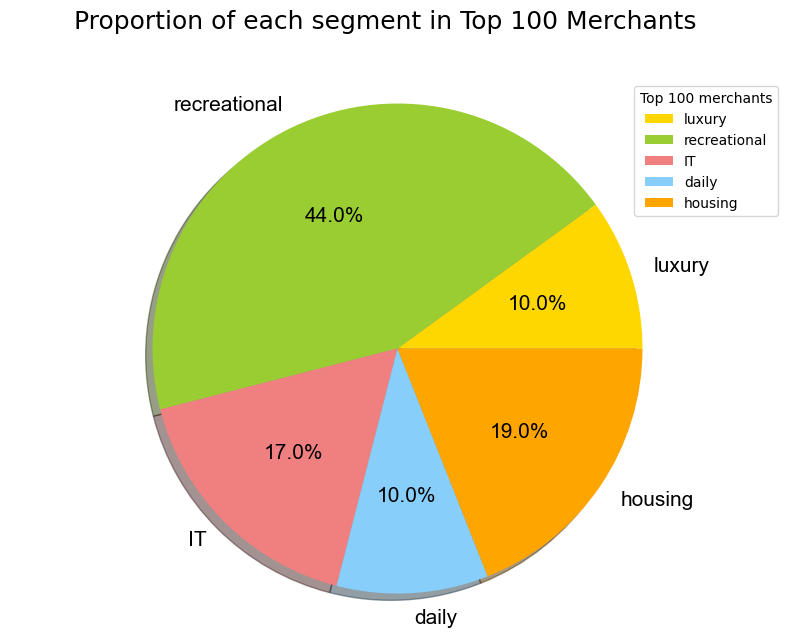

In [17]:
# number of merchants in each segment within the top 100
segment_count = Counter(list(top100_merchants['segment']))

# Data for the pie chart
labels = segment_count.keys()
counts = segment_count.values()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange']

# Plotting the pie chart
fig = plt.figure(figsize =(10, 7))
plt.pie(counts, 
        labels=labels,
        colors=colors, 
        autopct=lambda x: f'{x:.1f}%',
        textprops={"family": "Arial", "size": 15},
        shadow=True)
plt.axis('equal')
plt.legend(loc="best", title="Top 100 merchants")
fig.suptitle('Proportion of each segment in Top 100 Merchants', fontsize=18)
plt.savefig("../plots/proportion_bySegments.png", bbox_inches = 'tight')


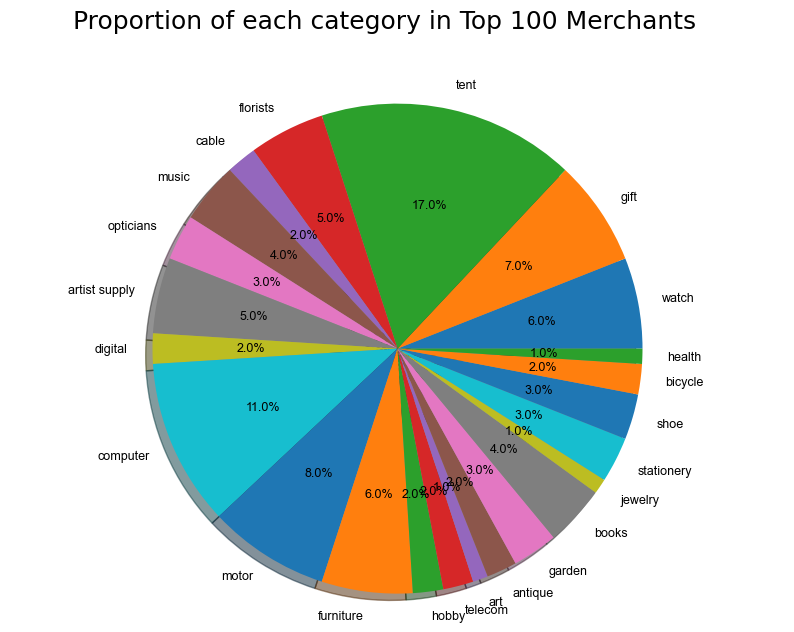

In [18]:
# number of merchants in each segment within the top 100
category_count = Counter(list(top100_merchants['category']))

# Data for the pie chart
labels = category_count.keys()
counts = category_count.values()
# colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red']

# Plotting the pie chart
fig = plt.figure(figsize =(10, 7))
plt.pie(counts, 
        labels=labels,
        autopct=lambda x: f'{x:.1f}%',
        textprops={"family": "Arial", "size": 9},
        shadow=True)
plt.axis('equal')
# plt.legend(loc="best", title="Top 100 merchants")
fig.suptitle('Proportion of each category in Top 100 Merchants', fontsize=18)
plt.savefig("../plots/proportion_byCategories.png", bbox_inches = 'tight')

In [22]:
print("Average rank of luxury merchants is", round(merchants_sorted[merchants_sorted['segment'] == 'luxury']['rank'].mean(),2))
print("Average rank of recreational merchants is", round(merchants_sorted[merchants_sorted['segment'] == 'recreational']['rank'].mean(),2))
print("Average rank of daily merchants is", round(merchants_sorted[merchants_sorted['segment'] == 'daily']['rank'].mean(),2))
print("Average rank of housing merchants is", round(merchants_sorted[merchants_sorted['segment'] == 'housing']['rank'].mean(),2))
print("Average rank of IT merchants is", round(merchants_sorted[merchants_sorted['segment'] == 'IT']['rank'].mean(),2))

Average rank of luxury merchants is 2339.53
Average rank of recreational merchants is 1941.76
Average rank of daily merchants is 2022.94
Average rank of housing merchants is 2000.95
Average rank of IT merchants is 1913.22


### ii) Comparison between top 100 and next 100 merchants

In [23]:
# next100_merchants = merchants_sorted.iloc[100:200]

segments = ['luxury', 'recreational', 'daily', 'housing', 'IT']

# normalize feature values based on top 200 merchants
merchant_segment = merchants_sorted['segment']
merchants_subset = merchants_sorted[criteria]
normalized_df= (merchants_subset - merchants_subset.min()) / (merchants_subset.max() - merchants_subset.min())
normalized_df['segment'] = merchant_segment

# get normalized feature values for top 100 merchants and next 100 merchants
top100_norm = normalized_df.head(100)
next100_norm = normalized_df.iloc[100:200]

In [24]:
# for top 100 merchatns and next 100 merchants, calculate the mean of normalized feature values
top100_mean_criteria = []
next100_mean_criteria = []
for criterion in criteria:
    top100_mean_criteria.append(top100_norm[criterion].mean())
    next100_mean_criteria.append(next100_norm[criterion].mean())

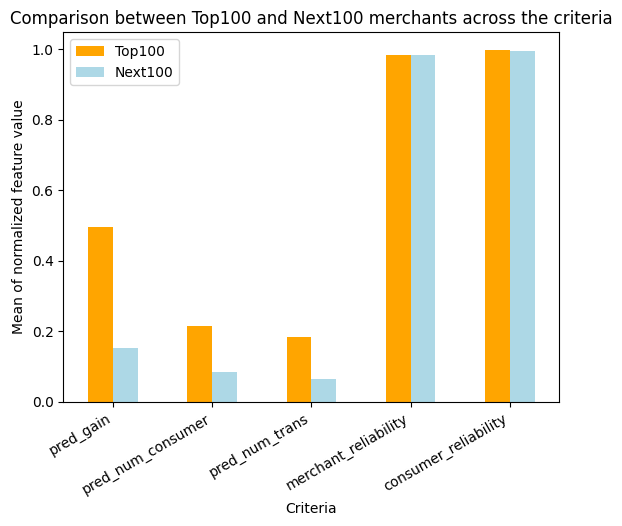

In [25]:
# plot the above data as bar graph
df = pd.DataFrame({'Top100': top100_mean_criteria,
                    'Next100': next100_mean_criteria}, index=criteria)
ax = df.plot.bar(rot=0, color={"Top100": "orange", "Next100": "lightblue"})
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xlabel('Criteria')
plt.ylabel('Mean of normalized feature value')
plt.title('Comparison between Top100 and Next100 merchants across the criteria')
plt.savefig("../plots/comparison_top100_next100.png", bbox_inches = 'tight')

### iii) Comparison across segments in feature values

For predicted gain, predicted number of consumers and predicted number of transactions in specific, compare the average feature values across the segments, with the top 100 merchants.

In [26]:
criteria2 = ['pred_gain', 'pred_num_consumer', 'pred_num_trans']
segments_dict = {}
i=1
# obtain the mean of normalized feature values for each segment
for criterion in criteria2:
    for segment in segments:
        if i==1:
            segments_dict[segment] = []
        segments_dict[segment].append(top100_norm[top100_norm['segment'] == segment][criterion].mean())
    i=0

Text(0.5, 1.0, 'Comparison between segments across the criteria')

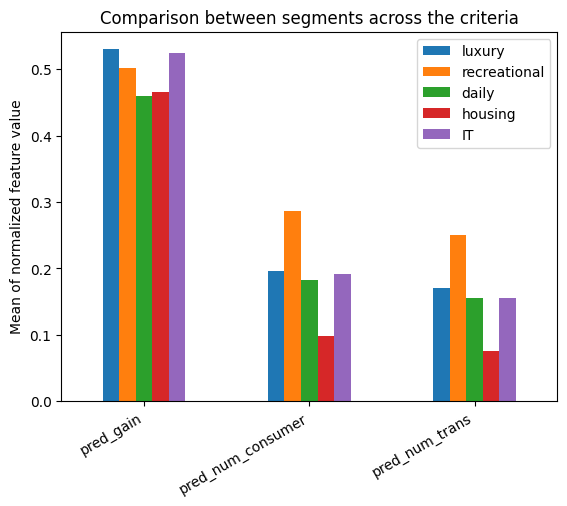

In [27]:
# plot the data obtained above as bar graph
df = pd.DataFrame({'luxury': segments_dict['luxury'],
                   'recreational': segments_dict['recreational'],
                   'daily': segments_dict['daily'],
                   'housing': segments_dict['housing'],
                   'IT': segments_dict['IT']}, index=criteria2)
ax = df.plot.bar(rot=0)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylabel('Mean of normalized feature value')
plt.title('Comparison between segments across the criteria')

### iv) getting statistics under our recommended top 100 merchants

In [28]:
for criterion in criteria2:
    print(criterion, '- sum: ', top100_merchants[criterion].sum())

pred_gain - sum:  20504560.659092326
pred_num_consumer - sum:  2916474.0
pred_num_trans - sum:  3376651.0


-> here, predicted total number of consumers in the above output is not a accurate measure of the total number of unique consumers

(because many of the consumers make transactions with multiple consumers)

In [29]:
# get unique number of consumers that the BNPL company can trade with under our recommended 100 merchants
top100_merchnats_name = list(top100_merchants['merchant_name'])
transactions = pd.read_parquet('../data/raw/transactions_clean')
transactions_filtered = transactions[transactions['merchant_name'].isin(top100_merchnats_name)]
len(set(transactions_filtered['consumer_id']))

24081

Under our recommended 100 merchants,

- predicted total gain in 2023 is around 23,000,000
- predicted total number of consumers is around 3,700,000
- predicted total number of unique consumers is around 24,000

In [30]:
# minimum merchant reliability under our 100 merchants
top100_merchants['merchant_reliability'].min()

0.9797772942531678

In [31]:
# minimum consumer reliability under our 100 merchants
top100_merchants['consumer_reliability'].min()

0.9211165048543688